# **Tarefa 3 - Árvore de decisão**

#### **Dicas:**

- Tutorial para iniciantes em Python: https://www.datacamp.com/cheat-sheet/getting-started-with-python-cheat-sheet

- Documentação do pandas: https://colab.research.google.com/drive/1a4sbKG7jOJGn4oeonQPA8XjJm7OYgcdX

- Documentação do scikit-learn: https://scikit-learn.org/stable/

- Documentação do matplotlib: https://matplotlib.org/stable/index.html

- Documentação do seaborn: https://seaborn.pydata.org/tutorial.html

---

#### Dataset:

Este conjunto de dados contém exemplos do problema de avaliação de carros, derivado de um modelo hierárquico de decisão originalmente desenvolvido para o sistema especialista DEX. O objetivo é prever a aceitabilidade de um carro (variável-alvo car), que pode assumir: unacc (inaceitável) e acc (aceitável), good (boa) e vgood (muito boa). O dataset relaciona diretamente a variável-alvo a seis atributos principais (buying, maint, doors, persons, lug_boot e safety).

#### Colunas:
	1.	buying → Preço de compra do carro. Valores: {vhigh, high, med, low}.
	2.	maint → Custo de manutenção do carro. Valores: {vhigh, high, med, low}.
	3.	doors → Número de portas do carro. Valores: {2, 3, 4, 5more}.
	4.	persons → Capacidade em termos de número de pessoas. Valores: {2, 4, more}.
	5.	lug_boot → Tamanho do porta-malas. Valores: {small, med, big}.
	6.	safety → Nível estimado de segurança do carro. Valores: {low, med, high}.
	7.	car → Variável-alvo. Aceitabilidade do carro. Valores: {unacc, acc, good e vgood}.


## **Importe os pacotes**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import plot_tree

## **Crie os datasets**

### **Crie um DataFrame a partir do arquivo de dados disponibilizados no EaD**

**Dicas:**

* Certifique-se que os arquivos a serem lidos estão carregados na sua sessão do Colab, ou em um drive previamente montado, e ajuste o comando para incluir todo o caminho até cada um dos arquivos a serem lidos.

In [ ]:
df_car = pd.read_csv('car_evaluation.csv')
df_car.head()

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


### **Transforme, na coluna `car` as categorias `vgood` e `good` em `acc`.**

In [ ]:
df_car['car'] = df_car['car'].replace(['vgood','good'],'acc')
display(df_car)

,buying,maint,doors,persons,lug_boot,safety,car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,acc
1724,low,low,5more,more,med,high,acc
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,acc


# **Pré-processamento**

Utilize o conhecimento adquirido nos exercícios anteriores para realizar o pré-processamento desta base de dados, incluindo normalização, tratamento de features categóricas e manipulação de possíveis valores nulos.

Para as colunas ordinais (que a ordem importa), transforme as colunas que se apresentam com valores na forma (1,2,3,4,5+) em (1,2,3,4,5), para que ela se mantenha numérica e a ordem preservada. Para as colunas ordinais que estão com nomes (ex.: baixo, médio, alto), transforme em números em uma escala.

In [ ]:
maping = {"buying": {"vhigh": 4, "high": 3, "med": 2, "low": 1}, 'maint': {"vhigh": 4, "high": 3, "med": 2, "low": 1},
          'doors': {"2": 2, "3": 3, "4": 4, "5more": 5}, 'persons': {"2": 2, "4": 4, "more": 5}, 'lug_boot': {"small": 1, "med": 2, "big": 3},
          'safety': {"low": 1, "med": 2, "high": 3}, 'car': {"unacc": 0, "acc": 1, "good": 2, "vgood": 3}}
df_car.replace(maping, inplace=True)


display(df_car.head())

/tmp/ipython-input-3662765357.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_car.replace(maping, inplace=True)


,buying,maint,doors,persons,lug_boot,safety,car
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0


In [ ]:
df_car['safety'].unique()

array([1, 2, 3])

# **Criação de Conjuntos de Treinamento, Teste**

Divida os dados em conjuntos de treino, validação e teste. Para isso, selecione aleatoriamente 70% dos registros, sem reposição, para o conjunto de treinamento. Os 30% restantes deverão ser divididos igualmente entre os conjuntos de validação e teste.

Dicas:

- Para fazer a divisão de treino, validação, teste use a função `train_test_split()` com `random_state = algum valor`

In [ ]:
df_car

,buying,maint,doors,persons,lug_boot,safety,car
0,4,4,2,2,1,1,0
1,4,4,2,2,1,2,0
2,4,4,2,2,1,3,0
3,4,4,2,2,2,1,0
4,4,4,2,2,2,2,0
...,...,...,...,...,...,...,...
1723,1,1,5,5,2,2,1
1724,1,1,5,5,2,3,1
1725,1,1,5,5,3,1,0
1726,1,1,5,5,3,2,1


In [ ]:


X = df_car.drop('car', axis=1)
y = df_car['car']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1209, 6)
(1209,)
(519, 6)
(519,)


#### Faça validação cruzada (dentro do conjunto de treino) com 5 folds utilizando o `StratifiedKFold` (busque por na biblioteca sklearn para realizar devidamente a importação da ferramenta) para avaliar Acurácia, Recall, Precisão e Score F1 (dica: importe `metrics` do sklearn), usando o `cross_val_score` (busque também na biblioteca sklearn) para diferentes valores de `max_depth` (de 3 a 6) (profundidade máxima que os nós da árvore podem chegar) ao treinar uma Árvore de Decisão (busque por `DecisionTreeClassifier` da biblioteca sklearn, que será nosso classificador).

> Observação: para reprodutibilidade, defina algum valor para o parâmetro random_state no classificador (`DecisionTreeClassifier(max_depth=..., random_state= algum valor)`) e também no `StratifiedKFold`.

#### Para cada valor de `max_depth` e para cada métrica, teremos 5 valores diferentes. Sendo assim, guarde em um DataFrame (ou outra estrutura de dado que achar conveniente), para cada valor de `max_depth`, a média e o desvio padrão de cada métrica.

> Dica: utilize um loop `for` para explorar os diferentes valores de `max_depth`.

In [ ]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score)
}

max_depths = [3, 4, 5, 6]
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
all_results = []

print(f"Iniciando a validação cruzada com {n_splits} folds...\n")

for depth in max_depths:
    display(depth)
    DT = DecisionTreeClassifier(max_depth=depth, random_state=42)
    for metric_name, scorer in scorers.items():

        scores = cross_val_score(DT, X, y, cv=skf, scoring=scorer)
        all_results.append({
            'max_depth': depth,
            'metrica': metric_name,
            'mean_score': np.mean(scores),
            'std_dev': np.std(scores)
        })
        print(f"  - Métrica '{metric_name}': Média = {np.mean(scores):.4f}, Desvio Padrão = {np.std(scores):.4f}")

print("\nValidação cruzada concluída!")

# 5. Criar e exibir o DataFrame com os resultados
results_df = pd.DataFrame(all_results)

print("\n---")
print("Sumário dos Resultados de Validação Cruzada:")
print(results_df)

Iniciando a validação cruzada com 5 folds...



3

  - Métrica 'accuracy': Média = 0.8692, Desvio Padrão = 0.0057
  - Métrica 'recall': Média = 0.6525, Desvio Padrão = 0.0256
  - Métrica 'precision': Média = 0.8804, Desvio Padrão = 0.0085
  - Métrica 'f1_score': Média = 0.7491, Desvio Padrão = 0.0157


4

  - Métrica 'accuracy': Média = 0.9248, Desvio Padrão = 0.0106
  - Métrica 'recall': Média = 0.9305, Desvio Padrão = 0.0130
  - Métrica 'precision': Média = 0.8380, Desvio Padrão = 0.0293
  - Métrica 'f1_score': Média = 0.8814, Desvio Padrão = 0.0145


5

  - Métrica 'accuracy': Média = 0.9265, Desvio Padrão = 0.0054
  - Métrica 'recall': Média = 0.8630, Desvio Padrão = 0.0338
  - Métrica 'precision': Média = 0.8899, Desvio Padrão = 0.0232
  - Métrica 'f1_score': Média = 0.8754, Desvio Padrão = 0.0109


6

  - Métrica 'accuracy': Média = 0.9635, Desvio Padrão = 0.0074
  - Métrica 'recall': Média = 0.9923, Desvio Padrão = 0.0072
  - Métrica 'precision': Média = 0.8974, Desvio Padrão = 0.0183
  - Métrica 'f1_score': Média = 0.9424, Desvio Padrão = 0.0113

Validação cruzada concluída!

---
Sumário dos Resultados de Validação Cruzada:
    max_depth    metrica  mean_score   std_dev
0           3   accuracy    0.869210  0.005677
1           3     recall    0.652483  0.025562
2           3  precision    0.880443  0.008492
3           3   f1_score    0.749141  0.015717
4           4   accuracy    0.924762  0.010567
5           4     recall    0.930471  0.012968
6           4  precision    0.837987  0.029262
7           4   f1_score    0.881399  0.014545
8           5   accuracy    0.926502  0.005397
9           5     recall    0.863032  0.033819
10          5  precision    0.889887  0.023172
11          5   f1_score    0.875415  0.010919
12          6   accuracy    0.963542  0.007449
13         

#### **Análise da Validação Cruzada, escolha do do modelo e avaliação no conjunto de teste**

> Baseado nos resultados, escolha o melhor valor de `max_depth`, justifique.

> Com o valor escolhido, treine uma Árvore de Decisão com o valor de `max_depth` no conjunto de Treino e avalie as métricas no conjunto de teste, reproduza uma matriz de confusão (busque por `confusion_matrix` do sklearn, já foi importada ao importar o `metrics` nos exercícios anteriores) e discuta o resultado.

Acurácia: 0.8555
Recall: 0.6218
Precisão: 0.8584
F1-Score: 0.7212


array([[347,  16],
       [ 59,  97]])

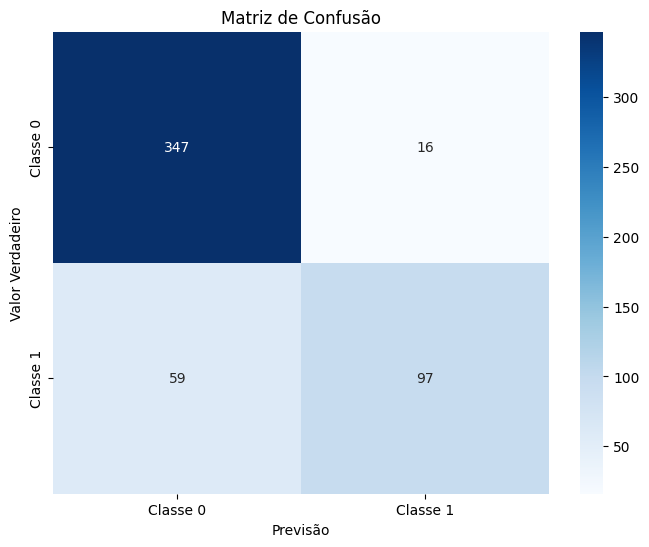

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify=y)
best_max_depth = 3
DT_final = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)

DT_final.fit(X_train, y_train)
y_pred = DT_final.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")


conf_matriz = confusion_matrix(y_test, y_pred)
display(conf_matriz)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsão')
plt.ylabel('Valor Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### **Feature Importance**

Utilizando o melhor modelo gere o gráfico de importância das features para o modelo que obteve o melhor desempenho nos dados de treino. Em seguida, **remova as** **três** **features com menor importância e realize novamente o treinamento com validação cruzada, para diferentes valores de `max_depth`.**



> Dica: Utilize o método `.feature_importances_` da biblioteca `sklearn` para obter os valores de importância de cada feature.



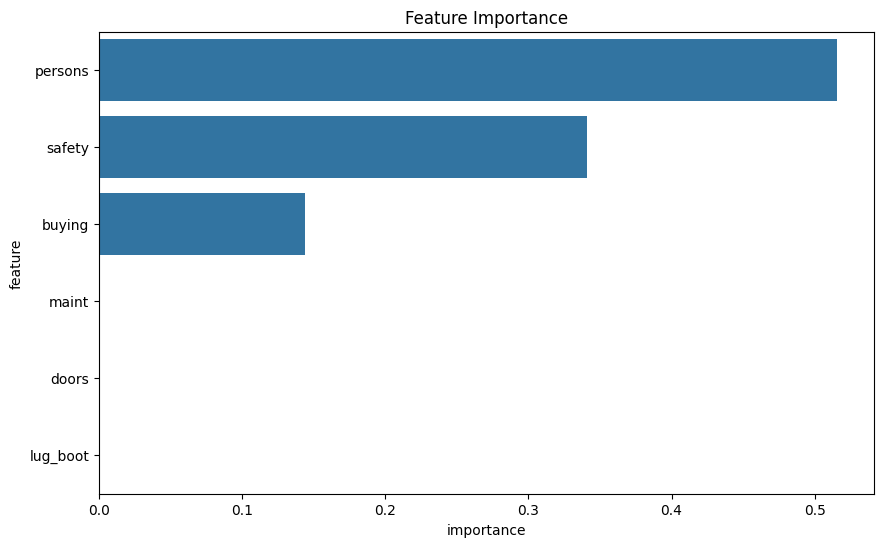

In [ ]:

feature_importances = DT_final.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


least_important_features = importance_df.tail(3)['feature'].tolist()


X_reduced = X.drop(columns=least_important_features)
y_reduced = y


In [ ]:
# Re-run cross-validation with the reduced dataset
all_results_reduced = []

print(f"\nIniciando a validação cruzada com {n_splits} folds no dataset reduzido...\n")

for depth in max_depths:
    display(depth)
    DT_reduced = DecisionTreeClassifier(max_depth=depth, random_state=42)
    for metric_name, scorer in scorers.items():
        scores_reduced = cross_val_score(DT_reduced, X_reduced, y_reduced, cv=skf, scoring=scorer)
        all_results_reduced.append({
            'max_depth': depth,
            'metrica': metric_name,
            'mean_score': np.mean(scores_reduced),
            'std_dev': np.std(scores_reduced)
        })
        print(f"  - Métrica '{metric_name}': Média = {np.mean(scores_reduced):.4f}, Desvio Padrão = {np.std(scores_reduced):.4f}")

print("\nValidação cruzada no dataset reduzido concluída!")

# Create and display the DataFrame with reduced dataset results
results_reduced_df = pd.DataFrame(all_results_reduced)

print("\n---")
print("Sumário dos Resultados de Validação Cruzada (Dataset Reduzido):")
print(results_reduced_df)


Iniciando a validação cruzada com 5 folds no dataset reduzido...



3

  - Métrica 'accuracy': Média = 0.8692, Desvio Padrão = 0.0057
  - Métrica 'recall': Média = 0.6525, Desvio Padrão = 0.0256
  - Métrica 'precision': Média = 0.8804, Desvio Padrão = 0.0085
  - Métrica 'f1_score': Média = 0.7491, Desvio Padrão = 0.0157


4

  - Métrica 'accuracy': Média = 0.8912, Desvio Padrão = 0.0075
  - Métrica 'recall': Média = 0.8745, Desvio Padrão = 0.0269
  - Métrica 'precision': Média = 0.7869, Desvio Padrão = 0.0162
  - Métrica 'f1_score': Média = 0.8280, Desvio Padrão = 0.0127


5

  - Métrica 'accuracy': Média = 0.8935, Desvio Padrão = 0.0054
  - Métrica 'recall': Média = 0.7856, Desvio Padrão = 0.0205
  - Métrica 'precision': Média = 0.8485, Desvio Padrão = 0.0183
  - Métrica 'f1_score': Média = 0.8155, Desvio Padrão = 0.0102


6

  - Métrica 'accuracy': Média = 0.8924, Desvio Padrão = 0.0060
  - Métrica 'recall': Média = 0.7915, Desvio Padrão = 0.0106
  - Métrica 'precision': Média = 0.8402, Desvio Padrão = 0.0132
  - Métrica 'f1_score': Média = 0.8151, Desvio Padrão = 0.0107

Validação cruzada no dataset reduzido concluída!

---
Sumário dos Resultados de Validação Cruzada (Dataset Reduzido):
    max_depth    metrica  mean_score   std_dev
0           3   accuracy    0.869210  0.005677
1           3     recall    0.652483  0.025562
2           3  precision    0.880443  0.008492
3           3   f1_score    0.749141  0.015717
4           4   accuracy    0.891200  0.007497
5           4     recall    0.874459  0.026893
6           4  precision    0.786942  0.016241
7           4   f1_score    0.828030  0.012667
8           5   accuracy    0.893513  0.005422
9           5     recall    0.785642  0.020487
10          5  precision    0.848540  0.018345
11          5   f1_score    0.815528  0.010213
12          6   acc

#### **Nova análise da Validação Cruzada, escolha do do modelo e avaliação no conjunto de teste**

> Baseado nos novos resultados, escolha o melhor valor de `max_depth`, justifique.

> Com o valor escolhido, treine uma Árvore de Decisão com o valor de `max_depth` no conjunto de Treino (reduzido) e avalie as métricas (as mesmas utilizadas acima) no conjunto de teste, reproduza uma matriz de confusão e discuta o resultado, comparando com os resultados da árvore treinada com mais features.

Metricas para o modelo com features reduzidos:
Acurácia: 0.8863
Recall: 0.8846
Precisão: 0.7709
F1-Score: 0.8239


array([[322,  41],
       [ 18, 138]])

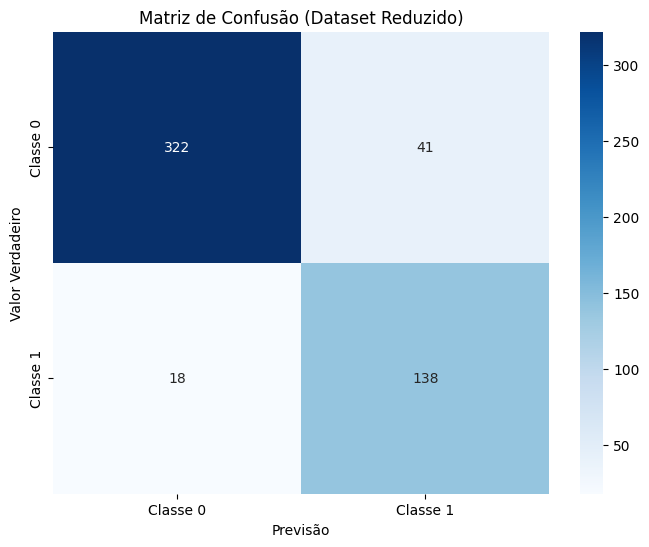


--- Discussion ---
Comparing the model trained on the full dataset (max_depth=3) and the model trained on the reduced dataset (max_depth=4):

Metrics for the model with full features:
Acurácia: 0.8555
Recall: 0.6218
Precisão: 0.8584
F1-Score: 0.7212

Metricas para o max_depth = 4
Acurácia: 0.8863
Recall: 0.8846
Precisão: 0.7709
F1-Score: 0.8239


In [ ]:
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.30, random_state=42, stratify=y_reduced)

# Define best_max_depth_reduced based on the analysis
best_max_depth_reduced = 4

DT_reduced_final = DecisionTreeClassifier(max_depth=best_max_depth_reduced, random_state=42)

DT_reduced_final.fit(X_train_reduced, y_train)

y_pred_reduced = DT_reduced_final.predict(X_test_reduced)

print("Metricas para o modelo com features reduzidos:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_reduced):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_reduced):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_reduced):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_reduced):.4f}")

# Display the confusion matrix for the model with reduced features
conf_matriz_reduced = confusion_matrix(y_test, y_pred_reduced)
display(conf_matriz_reduced)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matriz_reduced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Classe 0', 'Classe 1'],
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsão')
plt.ylabel('Valor Verdadeiro')
plt.title('Matriz de Confusão (Dataset Reduzido)')
plt.show()

# Discussion of results and comparison
print("\n--- Discussion ---")
print("Comparing the model trained on the full dataset (max_depth=3) and the model trained on the reduced dataset (max_depth=4):")
print("\nMetrics for the model with full features:")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}") # Using y_pred from the previous evaluation
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

print("\nMetricas para o max_depth = 4")
print(f"Acurácia: {accuracy_score(y_test, y_pred_reduced):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_reduced):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred_reduced):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_reduced):.4f}")

# **Plotar a árvore do melhor modelo**

Gere a visualização da Árvore de Decisão do novo modelo

**Dica:**

- Use a função `plot_tree()` da biblioteca `sklearn`

- Para tornar a visualização mais clara e facilitar a interpretação dos resultados, ajuste o parâmetro max_depth em `plot_tree(max_depth=?)`, limitando a profundidade da árvore exibida e destacando os nós mais significativos.

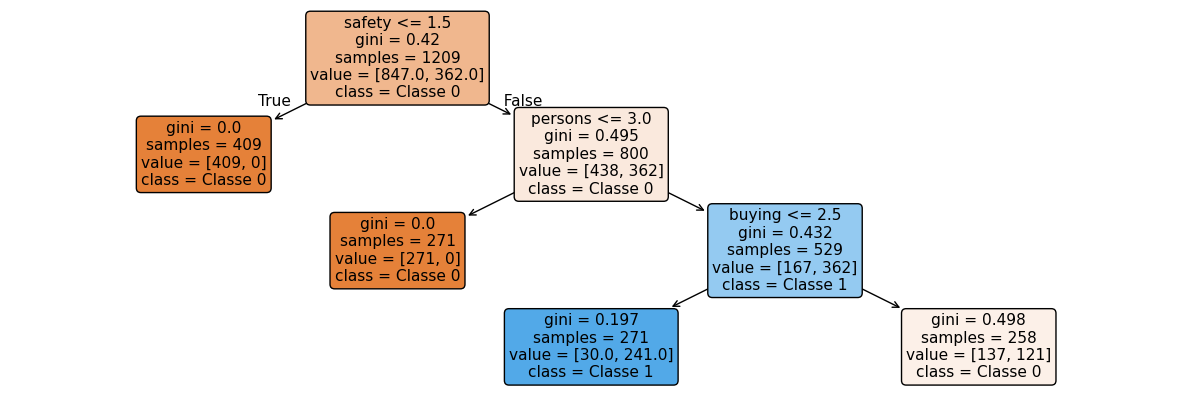

In [ ]:

feature_names = ['buying','maint','doors','persons','lug_boot','safety']
class_names = [f"Classe {c}" for c in np.unique(y)]
plt.figure(figsize=(15,5))
plot_tree(DT_final,
          filled=True,
          rounded=True,
          class_names=class_names,
          feature_names=feature_names,
          max_depth=best_max_depth)

plt.show()

# **Criação de Exemplos Fictícios**

Observe a estrutura da árvore de decisão treinada e crie dois exemplos fictícios, um para cada possível valor do target. Para cada exemplo, descreva detalhadamente o caminho que ele seguirá na árvore, ou seja, a sequência de nós que serão percorridos até chegar à folha correspondente.

Atributos: safety = 3; persons = 4 ; buying = 2 ; maint = 2; lug_boot = 2; dors=2

Raiz: safety <= 1.5 -> Falso (safety = 3)
Nó 1: persons <= 3.0 -> Falso ( persons = 4)
Nó 2: buyings <= 2.5 -> True (buying=2)
Folha: Classe 1 ( unacc ) modelo inaceitavel


Possível Gabarito:

**Exemplo 1 — Carro Aceitável (classe = 0)**

Atributos do exemplo:
	•	persons = 4
	•	safety = 3 (alto)
	•	buying = 1 (baixo)
	•	maint = 2 (médio)
	•	lug_boot = 3 (grande)
	•	doors = 4

Caminho percorrido na árvore:

	1.	Raiz: persons <= 2.5 → Falso (persons=4).

Caminho segue para o lado direito.

	2.	Nó seguinte: safety <= 1.5 → Falso (safety=3).

Caminho segue para baixo.

	3.	Próximo nó: buying <= 2.5 → Verdadeiro (buying=1).

Caminho segue para a esquerda.

	4.	Nó seguinte: maint <= 2.5 → Verdadeiro (maint=2).

Caminho segue para a esquerda.

	5.	Folha: classe 0 (acc).

Resultado: O carro é classificado como aceitável.


**Exemplo 2 — Carro Inaceitável (classe = 1)**

Atributos do exemplo:
	•	persons = 2
	•	safety = 1 (baixo)
	•	buying = 4 (muito alto)
	•	maint = 4 (muito alto)
	•	lug_boot = 1 (pequeno)
	•	doors = 2

Caminho percorrido na árvore:

	1.	Raiz: persons <= 2.5 → Verdadeiro (persons=2).

Caminho segue para a esquerda.

	2.	Folha atingida imediatamente: classe 1 (unacc).

Resultado: O carro é classificado como inaceitável.

# **Inferência e Verificação**

Realize uma inferência utilizando esses dois exemplos fictícios no modelo treinado. Verifique se os resultados obtidos na inferência correspondem aos valores do target que você imaginou ao criar os exemplos.

In [ ]:

example1_data = {'buying': [2], 'maint': [2], 'doors': [4], 'persons': [2], 'lug_boot': [4], 'safety': [4]}
example1_df = pd.DataFrame(example1_data)
example1_df.replace(maping, inplace=True)

example2_data = {'buying': [1], 'maint': [2], 'doors': [2], 'persons': [4], 'lug_boot': [2], 'safety': [3]}
example2_df = pd.DataFrame(example2_data)
example2_df.replace(maping, inplace=True)

fictional_examples_df = pd.concat([example1_df, example2_df], ignore_index=True)

predictions = DT_final.predict(fictional_examples_df)

print("Predictions for the fictional examples using DT_final:")
print(f"Example 1 Prediction: {predictions[0]} (Expected: 0)")
print(f"Example 2 Prediction: {predictions[1]} (Expected: 1)")



print(f"Predicted Class: {predictions[0]}")
print(f"Predicted Class: {predictions[1]}")

Predictions for the fictional examples using DT_final:
Example 1 Prediction: 0 (Expected: 0)
Example 2 Prediction: 1 (Expected: 1)
Predicted Class: 0
Predicted Class: 1


In [ ]:
fictional_examples_df

,buying,maint,doors,persons,lug_boot,safety
0,2,2,4,2,4,4
1,1,2,2,4,2,3


In [ ]:
feature_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']